In [1]:
%load_ext autoreload
%autoreload 2

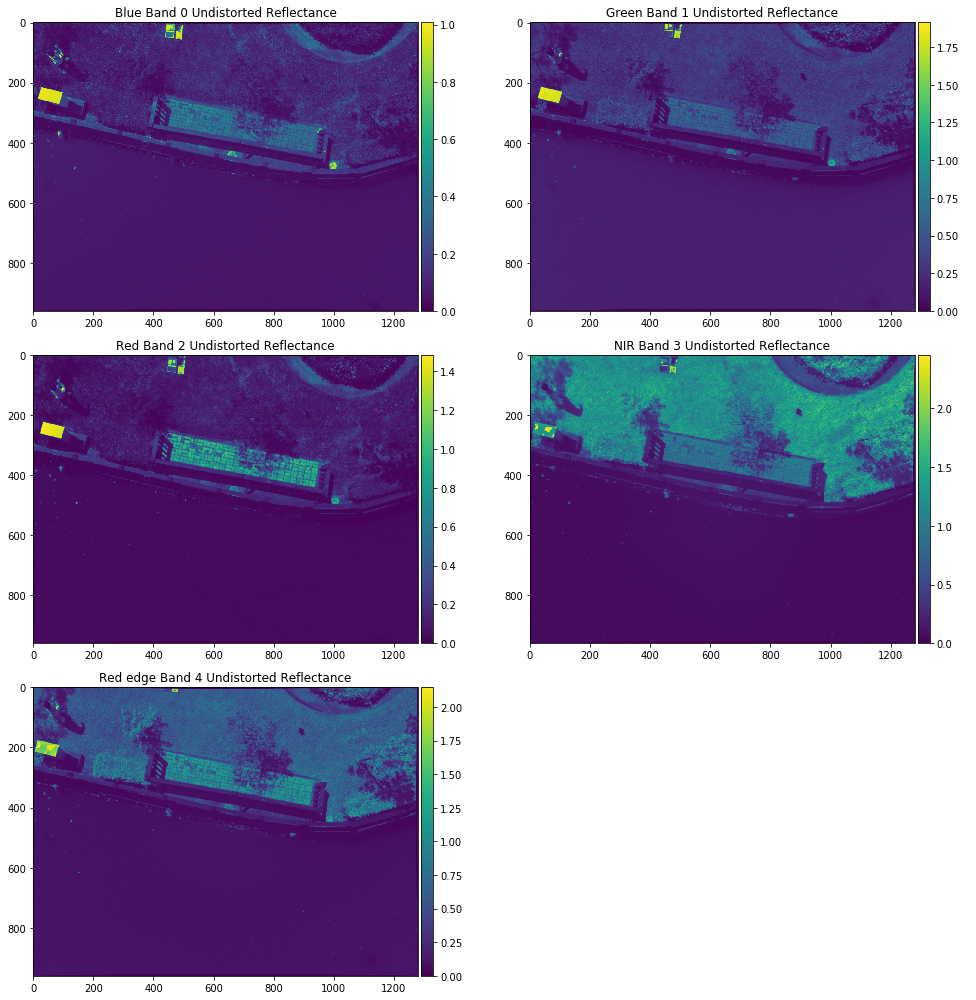

In [5]:
import os, glob
import micasense.capture as capture
%matplotlib inline

panelNames = None

# This is an altum image with RigRelatives and a thermal band
imagePath = os.path.join('.','data','ALTUM1SET','000')
imageNames = glob.glob(os.path.join(imagePath,'test','IMG_0066_*.tif'))
panelNames = glob.glob(os.path.join(imagePath,'test','IMG_0001_*.tif'))

if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
else:
    panelCap = None

capture = capture.Capture.from_filelist(imageNames)

for img in capture.images:
    if img.rig_relatives is None:
        raise ValueError("Images must have RigRelatives tags set which requires updated firmware and calibration. See the links in text above")

if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
    capture.plot_undistorted_reflectance(panel_irradiance)
else:
    if False: #capture.dls_present():
        img_type='reflectance'
        capture.plot_undistorted_reflectance(capture.dls_irradiance())
    else:
        img_type = "radiance"
        capture.plot_undistorted_radiance()

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

warp_mode = cv2.MOTION_HOMOGRAPHY
warp_matrices = capture.get_warp_matrices()

cropped_dimensions,edges = imageutils.find_crop_bounds(capture,warp_matrices)
im_aligned = imageutils.aligned_capture(capture, warp_matrices, warp_mode, cropped_dimensions, None, img_type=img_type)

print("warp_matrices={}".format(warp_matrices))

warp_matrices=[array([[ 1.00708067e+00, -5.71687664e-03, -4.07056558e+00],
       [ 6.81729215e-03,  1.00630344e+00,  3.67932118e-01],
       [ 1.08504511e-06,  9.03883799e-07,  1.00000000e+00]]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[ 1.00772573e+00, -6.96001403e-03, -1.13774230e+00],
       [ 7.86734950e-03,  1.00700873e+00,  1.14622819e+01],
       [ 8.90758693e-07,  7.31078404e-07,  1.00000000e+00]]), array([[ 1.00474787e+00, -2.57736667e-03, -1.35661154e+01],
       [ 2.07482732e-03,  1.00469141e+00,  1.26091322e+01],
       [-6.60683991e-07, -2.81652984e-07,  1.00000000e+00]]), array([[ 1.00813232e+00, -3.89299583e-03, -1.84500539e+01],
       [ 6.55335665e-03,  1.00994080e+00, -3.91544753e+01],
       [ 8.27235525e-07,  3.61033226e-06,  1.00000000e+00]])]


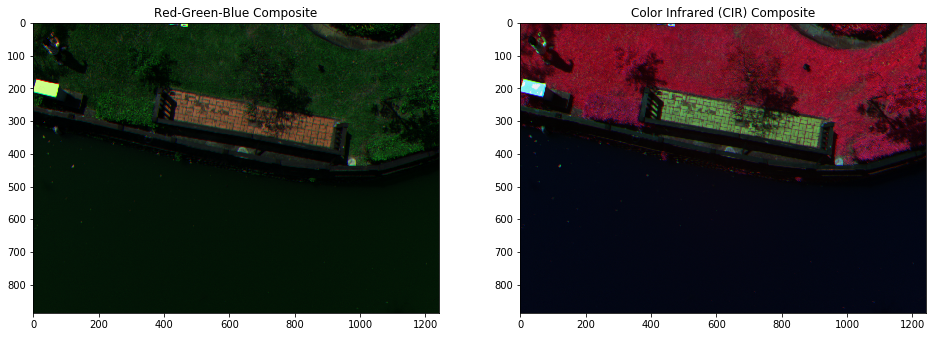

In [7]:
# figsize=(30,23) # use this size for full-image-resolution display
figsize=(16,13)   # use this size for export-sized display

rgb_band_indices = [2,1,0]
cir_band_indices = [3,2,1]

# Create an empty normalized stack for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],capture.num_bands+1), dtype=np.float32 )

im_min = np.percentile(im_aligned[:,:,0:2].flatten(),  0.1)  # modify with these percentilse to adjust contrast
im_max = np.percentile(im_aligned[:,:,0:2].flatten(), 99.9)  # for many images, 0.5 and 99.5 are good values

for i in range(0,im_aligned.shape[2]):
    if img_type == 'reflectance':
        # for reflectance images we maintain white-balance by applying the same display scaling to all bands
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)
    elif img_type == 'radiance':
        # for radiance images we do an auto white balance since we don't know the input light spectrum by
        # stretching each display band histogram to it's own min and max
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

rgb = im_display[:,:,rgb_band_indices]
# for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
# the classical CIR rendering where plants are red and soil takes on a blue tint
for i in cir_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

cir = im_display[:,:,cir_band_indices]
fig, axes = plt.subplots(1, 2, figsize=figsize)
axes[0].set_title("Red-Green-Blue Composite")
axes[0].imshow(rgb)
axes[1].set_title("Color Infrared (CIR) Composite")
axes[1].imshow(cir)
plt.show()

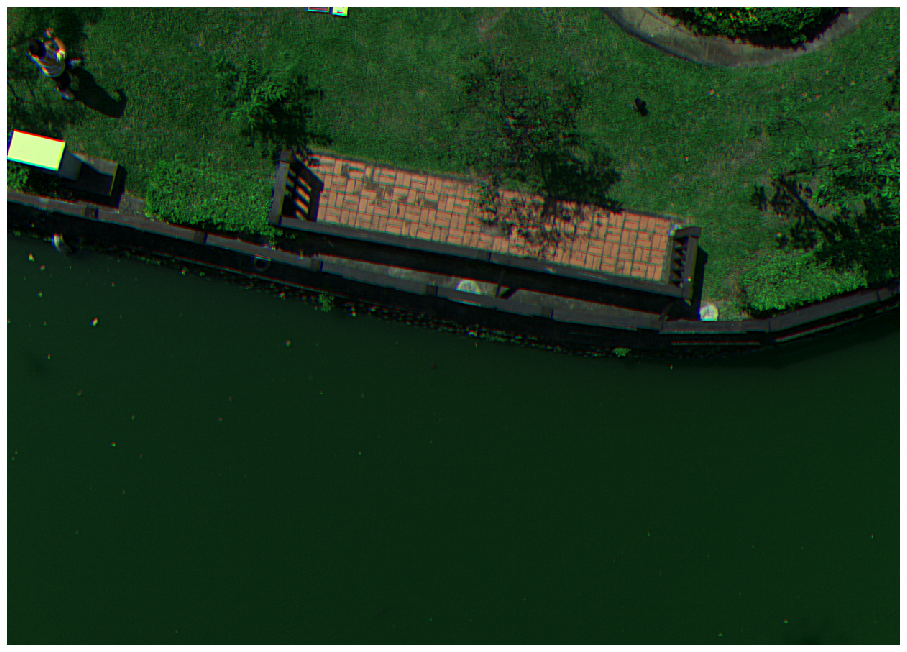

In [8]:
# Create an enhanced version of the RGB render using an unsharp mask
gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
gaussian_rgb[gaussian_rgb<0] = 0
gaussian_rgb[gaussian_rgb>1] = 1
unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
unsharp_rgb[unsharp_rgb<0] = 0
unsharp_rgb[unsharp_rgb>1] = 1

# Apply a gamma correction to make the render appear closer to what our eyes would see
gamma = 1.4
gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
fig = plt.figure(figsize=figsize)
plt.imshow(gamma_corr_rgb, aspect='equal')
plt.axis('off')
plt.show()